# Hyperspectral Analysis (Part 3)

## Spectral profile for spectral Library 2

### Import python modules

In [3]:
import re
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from shapely.geometry import box, Point
from scipy.ndimage import binary_opening, binary_closing, label, center_of_mass
from sklearn.metrics import roc_curve
from pathlib import Path

### Set Paths

In [4]:
BASE = Path("last/Classification/library")
BASE2 = Path("last/Classification/profiles")
LIB_FP   = BASE / "local_spectral_library_aviris2.csv"
WAVES_FP = BASE / "local_spectral_library_wavelengths.csv"

OUT_WIDE = BASE2 / "species_mean_normalised_profiles.csv"
OUT_TIDY = BASE2 / "species_normalised_profiles.csv"
OUT_PNG  = BASE2 / "species_mean_normalised_profiles.png"
OUT_PDF  = BASE2 / "species_mean_normalised_profiles.pdf"

### Configure

In [5]:
def detect_wavelength_vector(waves_df: pd.DataFrame) -> np.ndarray:
    num_cols = [c for c in waves_df.columns if np.issubdtype(waves_df[c].dtype, np.number)]
    if not num_cols:
        raise ValueError("No numeric wavelength column found in wavelengths file.")
    # Prefer a column that looks increasing and within plausible bounds
    for c in num_cols:
        v = waves_df[c].to_numpy()
        if len(v) >= 50 and v.min() >= 300 and v.max() <= 2600:
            if (np.diff(v) > 0).mean() > 0.9:
                return v.astype(float)
    return waves_df[num_cols[0]].to_numpy(dtype=float)

def detect_species_col(df: pd.DataFrame) -> str:
    for cand in ["Species", "GenusSpecies", "species", "genus_species", "Name"]:
        if cand in df.columns:
            return cand
    non_num = [c for c in df.columns if not np.issubdtype(df[c].dtype, np.number)]
    if non_num:
        return non_num[0]
    df["Species"] = [f"Sample_{i+1}" for i in range(len(df))]
    return "Species"

def detect_spectral_columns(df: pd.DataFrame, wavelengths: np.ndarray) -> list[str]:
    band_cols = [c for c in df.columns if str(c).startswith("Band_")]
    if band_cols:
        return band_cols
    num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    if len(num_cols) >= len(wavelengths):
        return num_cols[-len(wavelengths):]
    return num_cols  # fallback; will trim to min length

def bad_band_mask_nm(waves_nm: np.ndarray) -> np.ndarray:
    # Common AVIRIS-NG absorption/noise windows
    remove_ranges = [
        (-np.inf, 400),   # very short end
        (1340, 1445),     # ~1400 nm water absorption
        (1790, 1965),     # ~1900 nm water absorption
        (2450, np.inf),   # very long end
    ]
    mask = np.zeros_like(waves_nm, dtype=bool)
    for lo, hi in remove_ranges:
        mask |= (waves_nm >= lo) & (waves_nm <= hi)
    return mask

def vector_normalise(M: np.ndarray) -> np.ndarray:
    M = np.nan_to_num(M, nan=0.0)
    norm = np.sqrt((M**2).sum(axis=1, keepdims=True))
    norm[norm == 0] = 1.0
    return M / norm

### Read and Pick columns

In [6]:
# Read data
lib   = pd.read_csv(LIB_FP)
waves = pd.read_csv(WAVES_FP)
wavelengths = detect_wavelength_vector(waves)

# Pick columns
species_col = detect_species_col(lib)
spec_cols   = detect_spectral_columns(lib, wavelengths)

spec = lib[spec_cols].copy()
if spec.shape[1] != len(wavelengths):
    m = min(spec.shape[1], len(wavelengths))
    spec = spec.iloc[:, :m]
    wavelengths = wavelengths[:m]

### Clean values

In [7]:
spec = spec.replace(-9999, np.nan)
spec = spec.mask(spec < 0)  # any negative reflectance → NaN

# Remove bad bands
bad_mask = bad_band_mask_nm(wavelengths)
good_idx = np.where(~bad_mask)[0]
spec = spec.iloc[:, good_idx]
waves_good = wavelengths[good_idx]

### Vector normalise each sample

In [8]:
arr = spec.to_numpy(float)
vn = vector_normalise(arr)

vn_df = pd.DataFrame(vn, columns=[f"Band_{i+1}" for i in range(vn.shape[1])])
vn_df.insert(0, "Species", lib[species_col].astype(str).values)

### Average within each species

In [9]:
band_cols_now = [c for c in vn_df.columns if c != "Species"]
vn_mean = vn_df.groupby("Species")[band_cols_now].mean().reset_index()

### Export tidy and wide data

In [10]:
vn_mean.to_csv(OUT_WIDE, index=False)
tidy = vn_mean.melt(id_vars=["Species"], var_name="Band", value_name="NormReflectance")
tidy["Wavelength_nm"] = tidy.groupby("Species").cumcount().map(dict(enumerate(waves_good)))
tidy.sort_values(["Species", "Wavelength_nm"]).to_csv(OUT_TIDY, index=False)

### Plot single labelled figure

In [11]:
def plot_species_profiles(vn_mean, band_cols_now, waves_good, out_png, out_pdf=None):
    import numpy as np, matplotlib.pyplot as plt
    palette = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9'])
    styles  = ['-', '--', ':', '-.']
    labels = vn_mean["Species"].astype(str).tolist()
    n_colors = len(palette)

    plt.figure(figsize=(12, 7))
    Xw = waves_good
    for i, (_, row) in enumerate(vn_mean.iterrows()):
        yv = row[[c for c in vn_mean.columns if c != "Species"]].to_numpy(float)
        color = palette[i % n_colors]
        linestyle = styles[(i // n_colors) % len(styles)]
        plt.plot(Xw, yv, linewidth=1.3, color=color, linestyle=linestyle, label=labels[i])

    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Vector-normalised reflectance")
    plt.title("Species-level vector-normalised spectral profiles (bad bands removed)")
    plt.legend(labels, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=True)
    plt.tight_layout()
    plt.savefig(OUT_PNG, dpi=300, bbox_inches="tight")
    if OUT_PDF:
        plt.savefig(OUT_PDF, bbox_inches="tight")
    plt.show()

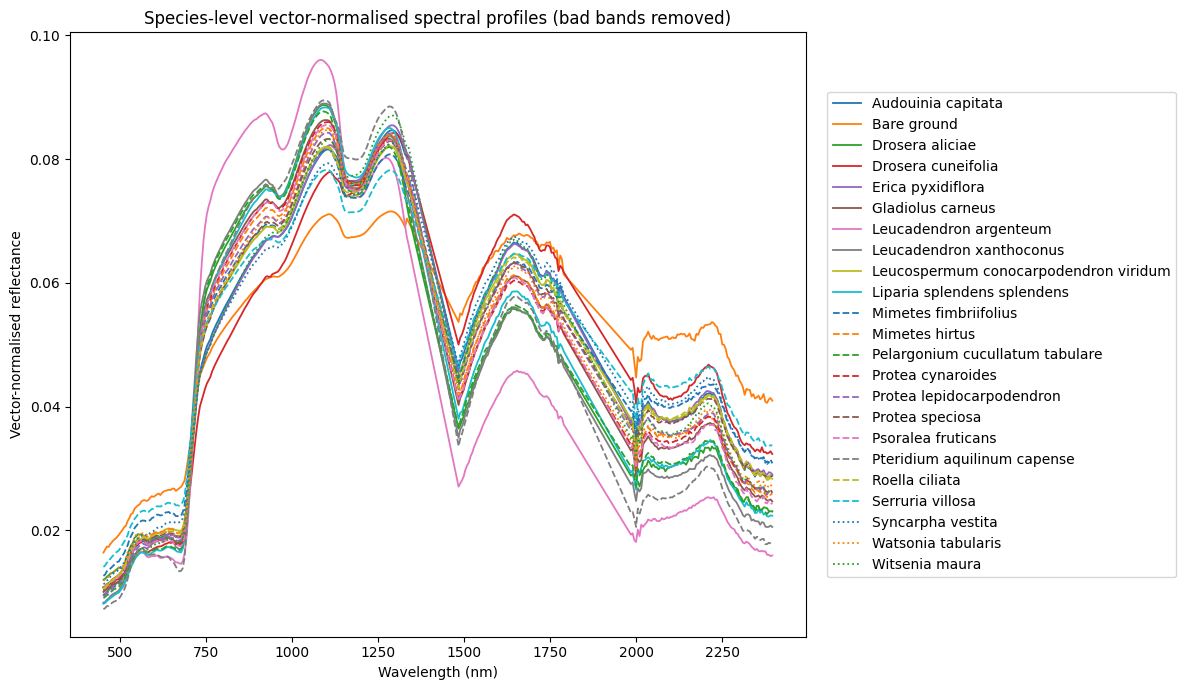

In [12]:
plot_species_profiles(
    vn_mean, 
    band_cols_now, 
    waves_good, 
    OUT_PNG, 
    OUT_PDF
)

### Highlight leucadendron argenteum

In [13]:
def plot_highlight_species(
    vn_mean, band_cols_now, waves_good, 
    highlight_species="Leucadendron argenteum", 
    out_png=None, out_pdf=None
):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 7))
    Xw = waves_good
    labels = vn_mean["Species"].astype(str).tolist()
    
    # Plot all species in gray
    for i, (_, row) in enumerate(vn_mean.iterrows()):
        yv = row[[c for c in vn_mean.columns if c != "Species"]].to_numpy(float)
        color = "gray"
        linewidth = 1
        alpha = 0.5
        label = None
        if row["Species"] == highlight_species:
            color = "red"
            linewidth = 3
            alpha = 1
            label = highlight_species
        plt.plot(Xw, yv, linewidth=linewidth, color=color, alpha=alpha, label=label)
    
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Vector-normalised reflectance")
    plt.title(f"Spectral profiles with {highlight_species} highlighted")
    if highlight_species in labels:
        plt.legend(loc="upper right")
    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=300, bbox_inches="tight")
    if out_pdf:
        plt.savefig(out_pdf, bbox_inches="tight")
    plt.show()

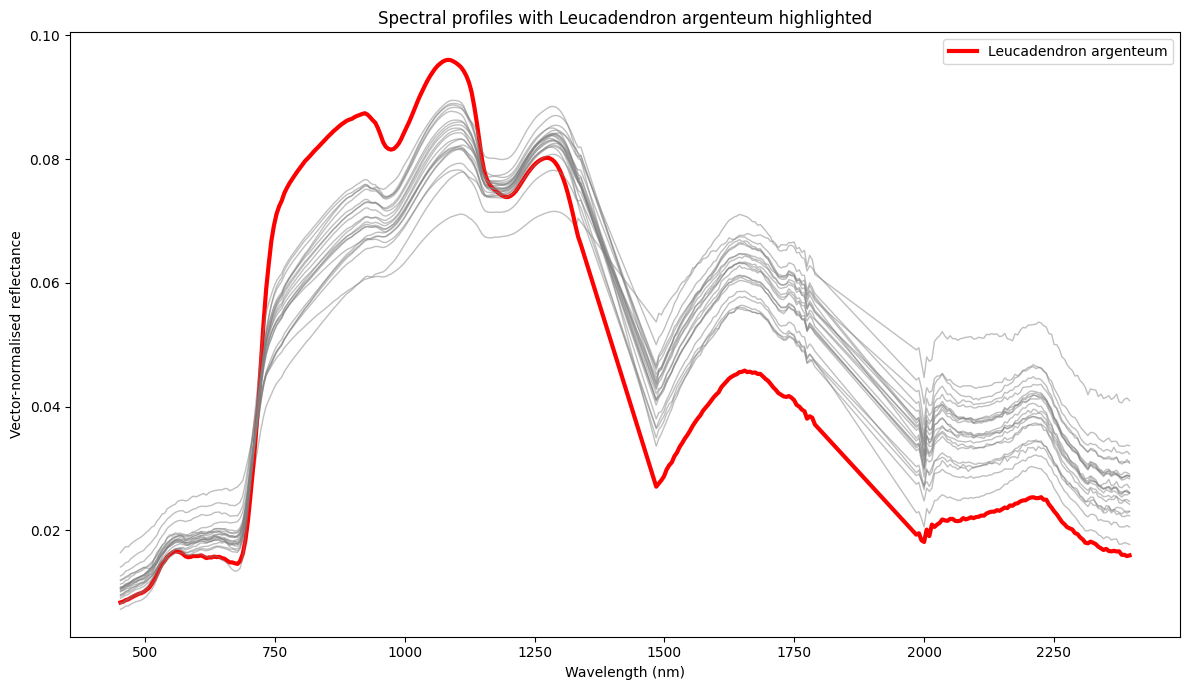

In [14]:
plot_highlight_species(
    vn_mean,
    band_cols_now,
    waves_good,
    highlight_species="Leucadendron argenteum",
    out_png=BASE2 / "highlight_leucadendron_argenteum.png",
    out_pdf=BASE2 / "highlight_leucadendron_argenteum.pdf"
)

## Classification Section

### Import python modules

In [15]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm, Normalize
from matplotlib.patches import Rectangle
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from scipy.stats import hypergeom

### Configure

In [51]:
LIB_FP = Path("last/Classification/library/local_spectral_library_aviris2.csv")

# Path to the CSV containing wavelength values for each reflectance band.
WAVES_FP = Path("last/Classification/library/local_spectral_library_wavelengths.csv")

# Directory where outputs (CSV files and figures) will be saved.
OUT_DIR = Path("last/Classification/stats")

# Number of principal components to retain for classification.
N_PCS = 10

# Number of permutations for estimating p-values on inter-species angles.
ANGLE_PERMUTATIONS = 999

# Colour map for heatmaps: SteelBlue3 → white → red.
STEELBLUE3 = "#4F94CD"
COLORMAP = LinearSegmentedColormap.from_list("steelwhiteRed",
                                              [STEELBLUE3, "white", "red"],
                                              N=256)

### Helper functions

In [50]:
def plot_heatmap(matrix: np.ndarray,
                 row_labels: list,
                 col_labels: list,
                 title: str,
                 out_png: Path,
                 out_pdf: Path,
                 pvals: np.ndarray | None = None,
                 triangle: str = "full",
                 value_fmt: str = "{:d}",
                 midpoint: float | None = None) -> None:
    n_rows, n_cols = matrix.shape
    # Determine which half to hide
    mask = np.zeros_like(matrix, dtype=bool)
    if triangle.lower() == "lower":
        mask[np.triu_indices(n_rows, k=1)] = True
    elif triangle.lower() == "upper":
        mask[np.tril_indices(n_rows, k=-1)] = True
    # Compute colour scaling on visible entries
    visible = matrix[~mask & ~np.isnan(matrix)]
    vmin, vmax = np.nanmin(visible), np.nanmax(visible)
    if midpoint is None:
        midpoint = float(np.nanmedian(visible))
    norm = TwoSlopeNorm(vmin=vmin, vcenter=midpoint, vmax=vmax)
    # Set up figure size proportional to matrix dimensions
    fig_w = max(6.0, 0.5 * n_cols + 3)
    fig_h = max(6.0, 0.5 * n_rows + 3)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    # Mask hidden half and NaNs
    mdata = np.ma.array(matrix, mask=mask | np.isnan(matrix))
    im = ax.imshow(mdata, cmap=COLORMAP, norm=norm, aspect="equal")
    # Axis ticks and labels
    ax.set_xticks(np.arange(n_cols))
    ax.set_yticks(np.arange(n_rows))
    ax.set_xticklabels(col_labels, rotation=90, ha="center")
    ax.set_yticklabels(row_labels)
    # Annotate each visible cell
    for i in range(n_rows):
        for j in range(n_cols):
            if mask[i, j] or np.isnan(matrix[i, j]):
                continue
            val = matrix[i, j]
            label = value_fmt.format(val)
            if pvals is not None:
                p = pvals[i, j]
                stars = ""
                if p < 0.001:
                    stars = "***"
                elif p < 0.01:
                    stars = "**"
                elif p < 0.05:
                    stars = "*"
                if stars:
                    label = f"{label}\n{stars}"
            ax.text(j, i, label, ha="center", va="center",
                    fontsize=8, color="black")
            # Draw a black border around each visible cell
            rect = Rectangle((j - 0.5, i - 0.5), 1, 1,
                             fill=False, edgecolor="black", linewidth=0.6)
            ax.add_patch(rect)
    # Title and colourbar
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Value", rotation=90)
    # Save the figure
    fig.tight_layout()
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    fig.savefig(out_pdf, dpi=300, bbox_inches="tight")
    plt.close(fig)

def plot_heatmap2(matrix: np.ndarray,
                 row_labels: list,
                 col_labels: list,
                 title: str,
                 out_png: Path,
                 out_pdf: Path,
                 pvals: np.ndarray | None = None,
                 triangle: str = "full",
                 value_fmt: str = "{:d}",
                 midpoint: float | None = None) -> None:
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import TwoSlopeNorm, Normalize, LinearSegmentedColormap
    from matplotlib.patches import Rectangle

    # Fallback colormap if COLORMAP isn't defined outside:
    if "COLORMAP" not in globals():
        steelblue3 = "#4F94CD"
        cmap = LinearSegmentedColormap.from_list("steelwhiteRed", [steelblue3, "white", "red"], N=256)
    else:
        cmap = COLORMAP

    # Basic sizes
    n_rows, n_cols = matrix.shape

    # Determine which half to hide
    mask = np.zeros_like(matrix, dtype=bool)
    tri = (triangle or "full").lower()
    if tri == "lower":
        mask[np.triu_indices(n_rows, k=1)] = True
    elif tri == "upper":
        mask[np.tril_indices(n_rows, k=-1)] = True

    # Visible values for scaling
    vals = np.asarray(matrix, dtype=float)
    visible = vals[~mask & np.isfinite(vals)]

    if visible.size == 0:
        # Nothing finite to plot; use a harmless norm
        norm = Normalize(vmin=0.0, vmax=1.0)
    else:
        vmin = float(np.nanmin(visible))
        vmax = float(np.nanmax(visible))
        mp   = float(np.nanmedian(visible) if midpoint is None else midpoint)

        if vmin == vmax:
            # Flat matrix → simple Normalize with tiny padding
            pad = 0.5 if value_fmt == "{:d}" else max(1e-6, 0.01 * abs(vmin) + 1e-6)
            norm = Normalize(vmin=vmin - pad, vmax=vmax + pad)
        else:
            # Ensure vmin < mp < vmax for TwoSlopeNorm
            if not (vmin < mp < vmax):
                eps = (vmax - vmin) * 1e-6 + 1e-9
                mp = min(max(mp, vmin + eps), vmax - eps)
            norm = TwoSlopeNorm(vmin=vmin, vcenter=mp, vmax=vmax)

    # Figure size proportional to matrix dimensions
    fig_w = max(6.0, 0.5 * n_cols + 3.0)
    fig_h = max(6.0, 0.5 * n_rows + 3.0)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    # Mask hidden half and NaNs
    mdata = np.ma.array(vals, mask=mask | ~np.isfinite(vals))
    im = ax.imshow(mdata, cmap=cmap, norm=norm, aspect="equal", interpolation="nearest")

    # Axis ticks and labels
    ax.set_xticks(np.arange(n_cols))
    ax.set_yticks(np.arange(n_rows))
    ax.set_xticklabels(col_labels, rotation=90, ha="center")
    ax.set_yticklabels(row_labels)

    # Annotate each visible cell + draw black borders
    for i in range(n_rows):
        for j in range(n_cols):
            if mask[i, j] or not np.isfinite(vals[i, j]):
                continue
            v = vals[i, j]
            # Safe integer formatting when fmt is "{:d}"
            label = (value_fmt.format(int(v)) if value_fmt == "{:d}" else value_fmt.format(v))

            if pvals is not None and np.isfinite(pvals[i, j]):
                p = float(pvals[i, j])
                if p < 0.001:
                    label = f"{label}\n***"
                elif p < 0.01:
                    label = f"{label}\n**"
                elif p < 0.05:
                    label = f"{label}\n*"

            ax.text(j, i, label, ha="center", va="center", fontsize=8, color="black")

            rect = Rectangle((j - 0.5, i - 0.5), 1, 1,
                             fill=False, edgecolor="black", linewidth=0.6)
            ax.add_patch(rect)

    # Title and colourbar
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Value", rotation=90)

    # Save
    fig.tight_layout()
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    fig.savefig(out_pdf, dpi=300, bbox_inches="tight")
    plt.close(fig)

### Load data

In [52]:
if __name__ == "__main__":
    # Ensure output directory exists
    OUT_DIR.mkdir(parents=True, exist_ok=True)

    # Load spectral library and wavelengths
    if not LIB_FP.exists() or not WAVES_FP.exists():
        print(f"Error: could not find {LIB_FP} or {WAVES_FP}.")
    else:
        lib = pd.read_csv(LIB_FP)
        waves = pd.read_csv(WAVES_FP)
        # Identify the wavelength vector (prefer an increasing numeric column)
        wl = None
        for col in waves.columns:
            if np.issubdtype(waves[col].dtype, np.number):
                vals = waves[col].to_numpy()
                if len(vals) >= 50 and vals.min() >= 300 and vals.max() <= 2600:
                    if (np.diff(vals) > 0).mean() > 0.9:
                        wl = vals.astype(float)
                        break
        if wl is None:
            # Fallback to the first numeric column
            num_cols = [c for c in waves.columns if np.issubdtype(waves[c].dtype, np.number)]
            wl = waves[num_cols[0]].to_numpy(dtype=float)

        # Identify the species column (look for common names)
        species_col = None
        for cand in ["Species", "GenusSpecies", "species", "genus_species", "Name"]:
            if cand in lib.columns:
                species_col = cand
                break
        if species_col is None:
            # Use the first non‐numeric column as species identifier
            for c in lib.columns:
                if not np.issubdtype(lib[c].dtype, np.number):
                    species_col = c
                    break
            if species_col is None:
                # As a last resort, create synthetic names
                lib["Species"] = [f"Sample_{i+1}" for i in range(len(lib))]
                species_col = "Species"

        # Identify reflectance columns (numeric) and align with wavelengths
        band_cols = [c for c in lib.columns if np.issubdtype(lib[c].dtype, np.number)]
        # Keep the last len(wl) numeric columns in case of extra metadata columns
        if len(band_cols) >= len(wl):
            band_cols = band_cols[-len(wl):]
        # Trim or pad wavelengths and bands to match
        if len(band_cols) != len(wl):
            m = min(len(band_cols), len(wl))
            band_cols = band_cols[:m]
            wl = wl[:m]

### Preprocess the data

In [53]:
spec = lib[band_cols].replace(-9999, np.nan)
spec = spec.mask(spec < 0)  # treat negative reflectance as missing

# Remove known bad bands (short/long wavelengths and water absorption)
bad_ranges = [(-np.inf, 400), (1340, 1445), (1790, 1965), (2450, np.inf)]
bad_mask = np.zeros(len(wl), dtype=bool)
for lo, hi in bad_ranges:
    bad_mask |= (wl >= lo) & (wl <= hi)
good_indices = np.where(~bad_mask)[0]
spec = spec.iloc[:, good_indices]
wl_good = wl[good_indices]

# Vector normalise each spectrum to unit length
arr = spec.to_numpy(dtype=float)
arr = np.nan_to_num(arr, nan=0.0)
norms = np.sqrt((arr ** 2).sum(axis=1, keepdims=True))
norms[norms == 0] = 1.0
vn = arr / norms

# Build a dataframe with species labels and normalised spectra
vn_df = pd.DataFrame(vn, columns=[f"B{i+1}" for i in range(vn.shape[1])])
vn_df.insert(0, "Species", lib[species_col].astype(str).values)

### Interspecies angles and p-values

In [54]:
species_names = vn_df["Species"].unique().tolist()
n_species = len(species_names)

# Compute unit‐length mean spectrum per species
species_means = {}
for sp in species_names:
    spectra = vn_df[vn_df["Species"] == sp].iloc[:, 1:].to_numpy()
    if len(spectra) == 0:
        continue
    mean_vec = spectra.mean(axis=0)
    norm = np.linalg.norm(mean_vec)
    if norm == 0:
        norm = 1.0
        mean_vec = np.zeros_like(mean_vec)
    species_means[sp] = mean_vec / norm
    
# Build angle matrix (degrees)
angles = np.zeros((n_species, n_species), dtype=float)
for i in range(n_species):
    for j in range(n_species):
        if i == j:
            angles[i, j] = 0.0
        else:
            a = species_means[species_names[i]]
            b = species_means[species_names[j]]
            dot = float(np.dot(a, b))
            dot = np.clip(dot, -1.0, 1.0)
            angle = np.degrees(np.arccos(dot))
            angles[i, j] = angle

### Permutation test for each pair to estimate p‐values

In [55]:
angle_pvals = np.full((n_species, n_species), np.nan)
rng = np.random.default_rng(42)

# Group spectra by species for quick access
spectra_by_sp = {sp: vn_df[vn_df["Species"] == sp].iloc[:, 1:].to_numpy()
                    for sp in species_names}
for i in range(n_species):
    for j in range(i + 1, n_species):
        # Skip trivial cases
        X_i = spectra_by_sp[species_names[i]]
        X_j = spectra_by_sp[species_names[j]]
        if X_i.shape[0] < 1 or X_j.shape[0] < 1:
            continue
        obs_angle = angles[i, j]
        pool = np.vstack((X_i, X_j))
        n_i = X_i.shape[0]
        count_ge = 0
        for _ in range(ANGLE_PERMUTATIONS):
            idx = rng.permutation(pool.shape[0])
            perm_i = pool[idx[:n_i]]
            perm_j = pool[idx[n_i:]]
            m_i = perm_i.mean(axis=0)
            m_j = perm_j.mean(axis=0)
            # Normalise
            norm_i = np.linalg.norm(m_i)
            norm_j = np.linalg.norm(m_j)
            if norm_i == 0 or norm_j == 0:
                continue
            m_i /= norm_i
            m_j /= norm_j
            perm_angle = np.degrees(
                np.arccos(
                    np.clip(float(np.dot(m_i, m_j)), -1.0, 1.0)
                )
            )
            if perm_angle >= obs_angle:
                count_ge += 1
        # p‐value: proportion of permuted angles >= observed angle
        pval = (count_ge + 1) / (ANGLE_PERMUTATIONS + 1)
        angle_pvals[i, j] = angle_pvals[j, i] = pval

### save angle matrices

In [56]:
pd.DataFrame(angles, index=species_names, columns=species_names).to_csv(OUT_DIR / "inter_species_angles_deg.csv")
pd.DataFrame(angle_pvals, index=species_names, columns=species_names).to_csv(OUT_DIR / "inter_species_angles_pvals.csv")

### Plot lower half of matrix

In [57]:
plot_heatmap(angles,
                species_names,
                species_names,
                "Inter‐species spectral angles (degrees)",
                OUT_DIR / "inter_species_angles_tri.png",
                OUT_DIR / "inter_species_angles_tri.pdf",
                pvals=angle_pvals,
                triangle="lower",
                value_fmt="{:.1f}",
                midpoint=None)

### Prep for classification

In [58]:
# Count number of samples per species and drop species with fewer than 2 samples
counts = vn_df["Species"].value_counts()
eligible = counts[counts >= 2].index.tolist()
df_cv = vn_df[vn_df["Species"].isin(eligible)].reset_index(drop=True)
X = df_cv.iloc[:, 1:].to_numpy(dtype=float)
y = df_cv["Species"].to_numpy()
if len(np.unique(y)) < 2:
    print("Not enough classes for classification.")
else:
    # PCA on the normalised spectra
    comps = min(N_PCS, X.shape[1] - 1) if X.shape[1] > 1 else 1
    pca = PCA(n_components=comps, random_state=0)
    Z = pca.fit_transform(X)
    # Determine number of folds based on smallest class
    min_class = counts[eligible].min()
    folds = 2
    if min_class >= 5:
        folds = 5
    elif min_class >= 3:
        folds = 3
    else:
        folds = 2
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    # Define classifiers
    classifiers = {
        "LogReg": LogisticRegression(max_iter=5000, multi_class="multinomial"),
        "SVM_Linear": SVC(kernel="linear", probability=False),
        "SVM_RBF": SVC(kernel="rbf", probability=False),
        "RandomForest": RandomForestClassifier(n_estimators=200, random_state=0),
        "kNN": KNeighborsClassifier(n_neighbors=3),
    }
    # Collect metrics in a list
    metrics_list = []
    labels_sorted = sorted(eligible)
    for name, clf in classifiers.items():
        preds = np.empty_like(y, dtype=object)
        # Cross‐validated predictions
        for train_idx, test_idx in skf.split(Z, y):
            clf.fit(Z[train_idx], y[train_idx])
            preds[test_idx] = clf.predict(Z[test_idx])
        # Compute confusion matrix
        cm = confusion_matrix(y, preds, labels=labels_sorted)
        # Compute per‐cell hypergeometric p‐values
        cm_pvals = np.full(cm.shape, np.nan)
        total = cm.sum()
        row_sums = cm.sum(axis=1)
        col_sums = cm.sum(axis=0)
        for i, true_lab in enumerate(labels_sorted):
            n = row_sums[i]
            for j, pred_lab in enumerate(labels_sorted):
                K = col_sums[j]
                x = cm[i, j]
                rv = hypergeom(total, K, n)
                # Right‐tail probability (>= x)
                pval = rv.sf(int(x) - 1)
                cm_pvals[i, j] = pval
        # Save matrices
        pd.DataFrame(cm, index=labels_sorted, columns=labels_sorted).to_csv(OUT_DIR / f"confusion_{name}.csv")
        pd.DataFrame(cm_pvals, index=labels_sorted, columns=labels_sorted).to_csv(OUT_DIR / f"confusion_{name}_pvals.csv")
        # Plot heatmap of confusion matrix
        plot_heatmap2(cm,
                        labels_sorted,
                        labels_sorted,
                        f"Confusion matrix ({name}, {folds}-fold CV)",
                        OUT_DIR / f"confusion_{name}.png",
                        OUT_DIR / f"confusion_{name}.pdf",
                        pvals=cm_pvals,
                        triangle="full",
                        value_fmt="{:d}",
                        midpoint=None)
        # Accuracy and macro F1
        acc = accuracy_score(y, preds)
        mF1 = f1_score(y, preds, average="macro")
        metrics_list.append({
            "Classifier": name,
            "Folds": folds,
            "Accuracy": acc,
            "MacroF1": mF1,
            "NumClasses": len(labels_sorted),
            "NumSamples": len(y),
        })

C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logisti

### Save

In [59]:
 # Save summary metrics
pd.DataFrame(metrics_list).to_csv(OUT_DIR / "classification_metrics.csv", index=False)

## Extract Leucadendron argenteum “accuracy” across models

In [60]:
TARGET = "Leucadendron argenteum" 
CLFS   = ["LogReg", "SVM_Linear", "SVM_RBF", "RandomForest", "kNN"]

def _norm(s):
    return str(s).strip().lower().replace("_", " ").replace("-", " ")

def _find_target_label(labels, target):
    labset = list(labels)
    # Exact (normalised) match first
    nmap = {_norm(l): l for l in labset}
    t = _norm(target)
    if t in nmap:
        return nmap[t]
    # Tolerant match: must contain both tokens
    for l in labset:
        ln = _norm(l)
        if "leucadendron" in ln and "argenteum" in ln:
            return l
    raise KeyError(f"Target '{target}' not found in labels: {labset[:6]}...")

rows, skipped = [], []
for name in CLFS:
    fp = OUT_DIR / f"confusion_{name}.csv"
    if not fp.exists():
        skipped.append(f"{name} (no confusion_{name}.csv)")
        continue

    cm = pd.read_csv(fp, index_col=0)
    try:
        tgt = _find_target_label(cm.index, TARGET)
    except KeyError:
        skipped.append(f"{name} (species not in folds/eligible)")
        continue

    TP = int(cm.loc[tgt, tgt])
    row_sum = int(cm.loc[tgt, :].sum())          # Actual Leucadendron
    col_sum = int(cm.loc[:, tgt].sum())          # Predicted Leucadendron
    total   = int(cm.values.sum())

    FN = row_sum - TP
    FP = col_sum - TP
    TN = total - TP - FP - FN

    # Producer's accuracy = recall for the class
    recall = TP / row_sum if row_sum else float("nan")
    # User's accuracy = precision for the class
    precision = TP / col_sum if col_sum else float("nan")
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else float("nan")

    rows.append({
        "Model": name,
        "Support (N_true)": row_sum,
        "TP": TP, "FP": FP, "FN": FN, "TN": TN,
        "Producer_Accuracy": recall,     # class accuracy you asked for
        "User_Accuracy": precision,
        "F1": f1,
    })

la_one = pd.DataFrame(rows).sort_values(by="Producer_Accuracy", ascending=False).reset_index(drop=True)
display(la_one)

# Persist alongside other stats
out_csv = OUT_DIR / "leucadendron_argenteum_by_model.csv"
try:
    la_one.to_csv(out_csv, index=False)
    print(f"Saved: {out_csv}")
except Exception as e:
    print(f"Note: could not save CSV ({e})")

if skipped:
    print("Skipped → " + "; ".join(skipped))

,Model,Support (N_true),TP,FP,FN,TN,Producer_Accuracy,User_Accuracy,F1
0,LogReg,20,19,89,1,250,0.95,0.175926,0.296875
1,RandomForest,20,18,14,2,325,0.90,0.562500,0.692308
2,SVM_RBF,20,16,51,4,288,0.80,0.238806,0.367816
3,SVM_Linear,20,13,50,7,289,0.65,0.206349,0.313253
4,kNN,20,4,21,16,318,0.20,0.160000,0.177778


Saved: last\Classification\stats\leucadendron_argenteum_by_model.csv


## Map L. argenteum

In [61]:
from pathlib import Path
import re, math
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import Window
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [73]:
ENVI_DIR = Path(r"data/AVNG_L2")
HDRS = sorted(ENVI_DIR.glob("*.hdr"))

TARGET_LABEL = "Leucadendron argenteum"  
HARD_THRESH = 0.7                         # Probability threshold for optional hard map
WRITE_HARD_MAP = True

MAP_DIR = OUT_DIR / "rf_maps_envi"
MAP_DIR.mkdir(parents=True, exist_ok=True)

# ── Final PCA + RF trained on ALL eligible samples ──
X_all = df_cv.iloc[:, 1:].to_numpy(float)
y_all = df_cv["Species"].astype(str).to_numpy()

comps = min(N_PCS, X_all.shape[1] - 1) if X_all.shape[1] > 1 else 1
pca_final = PCA(n_components=comps, random_state=0).fit(X_all)
Z_all = pca_final.transform(X_all)

rf_final = RandomForestClassifier(n_estimators=400, random_state=0, n_jobs=-1)
rf_final.fit(Z_all, y_all)

RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=0)

In [66]:
from pathlib import Path
import re
import numpy as np
import rasterio
from rasterio.windows import Window

ENVI_DIR = Path(r"data/AVNG_L2")
HDRS = sorted(ENVI_DIR.glob("*.hdr"))

def parse_envi_wavelengths(hdr_path: Path) -> np.ndarray:
    txt = hdr_path.read_text(errors="ignore")
    m = re.search(r"wavelength\s*=\s*\{([^}]*)\}", txt, flags=re.I | re.S)
    if not m:
        raise RuntimeError(f"No wavelength list in {hdr_path.name}")
    vals = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", m.group(1))
    return np.array([float(v) for v in vals], dtype=float)

def find_data_file(hdr_path: Path) -> Path:
    """Best-effort resolution of the ENVI raw file paired to this header."""
    txt = hdr_path.read_text(errors="ignore")
    # If header specifies an explicit data file
    m = re.search(r"data\s*file\s*=\s*([^\r\n\}]+)", txt, flags=re.I)
    cands = []
    if m:
        val = m.group(1).strip().strip('{}"\' ')
        cands.append(hdr_path.parent / val)
    # Common conventions: same stem with no extension, or .img/.dat/.bin
    stem0 = hdr_path.with_suffix("")
    cands += [stem0, stem0.with_suffix(".img"), stem0.with_suffix(".dat"), stem0.with_suffix(".bin")]
    for c in cands:
        if c.exists():
            return c
    raise FileNotFoundError(f"No ENVI data file found for {hdr_path.name}. Tried: " + ", ".join(map(str, cands)))


def process_tile(tile_brc, band_indexes_expected):
    # tile_brc: (B, rows, cols) float32 reflectance; uses pca_final & rf_final already fitted above
    B, r, c = tile_brc.shape
    M = r * c
    X = tile_brc.reshape(B, M).T
    X[X < 0] = 0.0
    n = np.sqrt((X * X).sum(axis=1, keepdims=True))
    n[n == 0] = 1.0
    Xn = X / n
    Z = pca_final.transform(Xn)
    P = rf_final.predict_proba(Z)[:, tgt_idx]
    return P.reshape(r, c).astype(np.float32)

def map_by_wavelength(train_wl: np.ndarray, cube_wl: np.ndarray, tol_nm: float = 2.5) -> list[int]:
    """Monotone nearest-neighbour mapping from training wavelengths to cube wavelengths (1-based for rasterio)."""
    idxs, j = [], 0
    for tw in train_wl:
        while j + 1 < len(cube_wl) and abs(cube_wl[j + 1] - tw) <= abs(cube_wl[j] - tw):
            j += 1
        idxs.append(j + 1 if abs(cube_wl[j] - tw) <= tol_nm else -1)
    ok = [i for i in idxs if i > 0]
    if len(ok) / len(idxs) < 0.9:
        raise RuntimeError(f"Wavelength match too low ({len(ok)/len(idxs):.1%}); widen tol_nm or check bandsets.")
    # Fill any -1 by nearest valid neighbour to preserve length
    for k in range(len(idxs)):
        if idxs[k] == -1:
            left = max([i for i in range(k, -1, -1) if idxs[i] > 0], default=None)
            right = min([i for i in range(k, len(idxs)) if idxs[i] > 0], default=None)
            pick = left if right is None else right if left is None else (left if abs(wl_good[k]-wl_good[left]) <= abs(wl_good[right]-wl_good[k]) else right)
            idxs[k] = idxs[pick]
    return idxs

for hdr in HDRS:
    cube_wl = parse_envi_wavelengths(hdr)
    sel_bands = map_by_wavelength(np.asarray(wl_good, float), cube_wl, tol_nm=2.5)
    data_fp = find_data_file(hdr)                     # ← open this, not the .hdr

    with rasterio.open(data_fp) as src:
        height, width, bands = src.height, src.width, src.count
        if max(sel_bands) > bands:
            raise RuntimeError(f"{hdr.name}: selected band index exceeds band count ({max(sel_bands)} > {bands})")

        prof = src.profile.copy()
        prof.update({
            "count": 1, "dtype": "float32", "compress": "LZW", "tiled": True,
            "blockxsize": min(512, width), "blockysize": min(512, height),
            "BIGTIFF": "IF_SAFER"
        })

        prob_fp = MAP_DIR / f"{hdr.stem}_LEARG_RF_prob.tif"
        with rasterio.open(prob_fp, "w", **prof) as dst:
            if src.block_shapes and src.block_shapes[0]:
                bh, bw = src.block_shapes[0]
            else:
                bh, bw = 512, 512
            for row_off in range(0, height, bh):
                for col_off in range(0, width, bw):
                    h = min(bh, height - row_off)
                    w = min(bw, width - col_off)
                    win = Window(col_off, row_off, w, h)
                    tile = src.read(indexes=sel_bands, window=win, out_dtype="float32")
                    prob_tile = process_tile(tile, sel_bands)
                    dst.write(prob_tile, 1, window=win)

    print(f"Wrote probability map → {prob_fp}")

    if WRITE_HARD_MAP:
        hard_fp = MAP_DIR / f"{hdr.stem}_LEARG_RF_hard.tif"
        with rasterio.open(prob_fp) as pr:
            prof2 = pr.profile.copy()
            prof2.update({"dtype": "uint8"})
            with rasterio.open(hard_fp, "w", **prof2) as dst_h:
                if pr.block_shapes and pr.block_shapes[0]:
                    bh, bw = pr.block_shapes[0]
                else:
                    bh, bw = 512, 512
                for row_off in range(0, pr.height, bh):
                    for col_off in range(0, pr.width, bw):
                        h = min(bh, pr.height - row_off)
                        w = min(bw, pr.width - col_off)
                        win = Window(col_off, row_off, w, h)
                        p = pr.read(1, window=win)
                        dst_h.write((p >= HARD_THRESH).astype(np.uint8), 1, window=win)
        print(f"Wrote hard class map (threshold={HARD_THRESH}) → {hard_fp}")

Wrote probability map → last\Classification\stats\rf_maps_envi\ang20231109t125547_021_L2A_OE_main_27577724_RFL_ORT_LEARG_RF_prob.tif


ValueError: Given nodata value, -9999.0, is beyond the valid range of its data type, uint8.

In [67]:
from pathlib import Path
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.merge import merge as rio_merge
from rasterio.mask import mask as rio_mask
import fiona
from shapely.geometry import shape, mapping
from shapely.ops import unary_union
from pyproj import Transformer

In [74]:
ENVI_DIR      = Path(r"data/AVNG_L2")  # folder with .hdr files
CLIP_VECTOR   = Path(r"Geethen Mode/Phemelo_TMNP.gpkg") 
CLIP_LAYER    = None  # for GPKG/SHP with multiple layers; None -> first layer
BLEND_METHOD  = "max"  # 'max' tends to hide seams for probabilities; alternatives require custom logic

In [75]:
HDRS = sorted(ENVI_DIR.glob("*.hdr"))
if not HDRS:
    raise FileNotFoundError(f"No .hdr files found in {ENVI_DIR}")

per_cube_prob = []
per_cube_hard = []

for idx, hdr in enumerate(HDRS, 1):
    cube_wl = parse_envi_wavelengths(hdr)
    sel_bands = map_by_wavelength(np.asarray(wl_good, float), cube_wl, tol_nm=2.5)
    data_fp = find_data_file(hdr)  # open the raw dataset, not the .hdr

    with rasterio.open(data_fp) as src:
        height, width, bands = src.height, src.width, src.count
        if max(sel_bands) > bands:
            raise RuntimeError(f"{hdr.name}: selected band index exceeds band count ({max(sel_bands)} > {bands})")

        prof = src.profile.copy()
        prof.update({
            "count": 1, "dtype": "float32", "compress": "LZW", "tiled": True,
            "blockxsize": min(512, width), "blockysize": min(512, height),
            "BIGTIFF": "IF_SAFER"
        })

        prob_fp = MAP_DIR / f"{hdr.stem}_LEARG_RF_prob.tif"
        with rasterio.open(prob_fp, "w", **prof) as dst:
            # use native tiling if present; else 512x512
            if src.block_shapes and src.block_shapes[0]:
                bh, bw = src.block_shapes[0]
            else:
                bh, bw = 512, 512

            for row_off in range(0, height, bh):
                for col_off in range(0, width, bw):
                    h = min(bh, height - row_off)
                    w = min(bw, width - col_off)
                    win = Window(col_off, row_off, w, h)
                    tile = src.read(indexes=sel_bands, window=win, out_dtype="float32")
                    prob_tile = process_tile(tile, sel_bands)
                    dst.write(prob_tile, 1, window=win)

        per_cube_prob.append(prob_fp)
        print(f"[{idx}/{len(HDRS)}] prob → {prob_fp}")

        if WRITE_HARD_MAP:
            hard_fp = MAP_DIR / f"{hdr.stem}_LEARG_RF_hard.tif"
            with rasterio.open(prob_fp) as pr:
                prof2 = pr.profile.copy()
                # Fix the nodata/type mismatch: choose a valid uint8 nodata.
                # Option A (simplest): nodata = 0 (means “absence or nodata”)
                prof2.pop("nodata", None)
                prof2.update({
                    "dtype": "uint8",
                    "nodata": 0,
                    "compress": "LZW",
                    "tiled": True,
                    "BIGTIFF": "IF_SAFER"
                })

                with rasterio.open(hard_fp, "w", **prof2) as dst_h:
                    if pr.block_shapes and pr.block_shapes[0]:
                        bh, bw = pr.block_shapes[0]
                    else:
                        bh, bw = 512, 512

                    for row_off in range(0, pr.height, bh):
                        for col_off in range(0, pr.width, bw):
                            h = min(bh, pr.height - row_off)
                            w = min(bw, pr.width - col_off)
                            win = Window(col_off, row_off, w, h)

                            p = pr.read(1, window=win)          # float32 prob tile
                            cls = (p >= HARD_THRESH).astype("uint8")
                            # If you want to treat NaNs as nodata explicitly, uncomment:
                            # mask_nan = np.isnan(p)
                            # cls[mask_nan] = 0

                            dst_h.write(cls, 1, window=win)

            per_cube_hard.append(hard_fp)
            print(f"[{idx}/{len(HDRS)}] hard → {hard_fp}")

[1/75] prob → last\Classification\stats\rf_maps_envi\ang20231109t125547_021_L2A_OE_main_27577724_RFL_ORT_LEARG_RF_prob.tif
[1/75] hard → last\Classification\stats\rf_maps_envi\ang20231109t125547_021_L2A_OE_main_27577724_RFL_ORT_LEARG_RF_hard.tif
[2/75] prob → last\Classification\stats\rf_maps_envi\ang20231109t130728_000_L2A_OE_main_27577724_RFL_ORT_LEARG_RF_prob.tif
[2/75] hard → last\Classification\stats\rf_maps_envi\ang20231109t130728_000_L2A_OE_main_27577724_RFL_ORT_LEARG_RF_hard.tif
[3/75] prob → last\Classification\stats\rf_maps_envi\ang20231109t130728_001_L2A_OE_main_27577724_RFL_ORT_LEARG_RF_prob.tif
[3/75] hard → last\Classification\stats\rf_maps_envi\ang20231109t130728_001_L2A_OE_main_27577724_RFL_ORT_LEARG_RF_hard.tif
[4/75] prob → last\Classification\stats\rf_maps_envi\ang20231109t130728_002_L2A_OE_main_27577724_RFL_ORT_LEARG_RF_prob.tif
[4/75] hard → last\Classification\stats\rf_maps_envi\ang20231109t130728_002_L2A_OE_main_27577724_RFL_ORT_LEARG_RF_hard.tif
[5/75] prob → la

In [76]:
# MOSAIC: probability (float32)
srcs = [rasterio.open(fp) for fp in per_cube_prob]
try:
    mosaic_prob, mosaic_transform = rio_merge(srcs, method=BLEND_METHOD)
finally:
    for s in srcs: s.close()

ref = rasterio.open(per_cube_prob[0])
mos_prof = ref.profile.copy()
mos_prof.update({
    "height": mosaic_prob.shape[1],
    "width": mosaic_prob.shape[2],
    "transform": mosaic_transform,
    "count": 1,
    "dtype": "float32",
    "compress": "LZW",
    "tiled": True,
    "BIGTIFF": "IF_SAFER"
})
mosaic_prob_fp = MAP_DIR / "LEARG_RF_prob_mosaic.tif"
with rasterio.open(mosaic_prob_fp, "w", **mos_prof) as dst:
    dst.write(mosaic_prob[0], 1)
print(f"Mosaic (prob) → {mosaic_prob_fp}")

# MOSAIC: hard mask (uint8), if requested 
mosaic_hard_fp = None
if WRITE_HARD_MAP and per_cube_hard:
    srcs = [rasterio.open(fp) for fp in per_cube_hard]
    try:
        mosaic_hard, mosaic_transform2 = rio_merge(srcs, method="max")  # logical OR across overlaps
    finally:
        for s in srcs: s.close()

    refh = rasterio.open(per_cube_hard[0])
    mos_prof2 = refh.profile.copy()
    mos_prof2.update({
        "height": mosaic_hard.shape[1],
        "width": mosaic_hard.shape[2],
        "transform": mosaic_transform2,
        "count": 1,
        "dtype": "uint8",
        "compress": "LZW",
        "tiled": True,
        "BIGTIFF": "IF_SAFER"
    })
    mosaic_hard_fp = MAP_DIR / "LEARG_RF_hard_mosaic.tif"
    with rasterio.open(mosaic_hard_fp, "w", **mos_prof2) as dst:
        dst.write(mosaic_hard[0].astype("uint8"), 1)
    print(f"Mosaic (hard) → {mosaic_hard_fp}")

Mosaic (prob) → last\Classification\stats\rf_maps_envi\LEARG_RF_prob_mosaic.tif
Mosaic (hard) → last\Classification\stats\rf_maps_envi\LEARG_RF_hard_mosaic.tif


In [77]:
# OPTIONAL CLIP to boundary
def _read_union_geom(vec_path: Path, layer: str | None):
    with fiona.open(vec_path, layer=layer) as srcv:
        geoms = [shape(feat["geometry"]) for feat in srcv if feat["geometry"]]
        u = unary_union(geoms)
        vcrs = srcv.crs_wkt or srcv.crs  # crs may be dict or WKT
    return u, vcrs

def _reproject_geom(geom, src_crs, dst_crs):
    # shapely coords reprojection
    transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)
    def _reproj_coords(coords):
        xs, ys = zip(*coords)
        x2, y2 = transformer.transform(xs, ys)
        return list(zip(x2, y2))
    def _reproj_geom(g):
        if g.geom_type in ("Polygon", "MultiPolygon", "LinearRing"):
            return shapely.ops.transform(lambda x, y: transformer.transform(x, y), g)
        return shapely.ops.transform(lambda x, y: transformer.transform(x, y), g)
    # simpler: use shapely.ops.transform
    import shapely.ops
    return shapely.ops.transform(lambda x, y: transformer.transform(x, y), geom)

def _clip_raster(in_fp: Path, out_fp: Path, clip_geom, clip_crs, nodata_value=None):
    with rasterio.open(in_fp) as src:
        # reproject geometry to raster CRS
        if clip_crs is not None and src.crs is not None and str(clip_crs) != str(src.crs):
            geom_proj = _reproject_geom(clip_geom, clip_crs, src.crs)
        else:
            geom_proj = clip_geom
        out_img, out_transform = rio_mask(src, [mapping(geom_proj)], crop=True, nodata=nodata_value)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_img.shape[1],
            "width": out_img.shape[2],
            "transform": out_transform
        })
        with rasterio.open(out_fp, "w", **out_meta) as dst:
            dst.write(out_img)

if CLIP_VECTOR.exists():
    clip_geom, clip_crs = _read_union_geom(CLIP_VECTOR, CLIP_LAYER)

    # clip prob mosaic
    clip_prob_fp = MAP_DIR / "LEARG_RF_prob_mosaic_clipped.tif"
    _clip_raster(mosaic_prob_fp, clip_prob_fp, clip_geom, clip_crs, nodata_value=np.nan)
    print(f"Clipped (prob) → {clip_prob_fp}")

    # clip hard mosaic (if present)
    if mosaic_hard_fp:
        clip_hard_fp = MAP_DIR / "LEARG_RF_hard_mosaic_clipped.tif"
        _clip_raster(mosaic_hard_fp, clip_hard_fp, clip_geom, clip_crs, nodata_value=0)
        print(f"Clipped (hard) → {clip_hard_fp}")
else:
    print("No clipping: CLIP_VECTOR path not found (skipped).")

Clipped (prob) → last\Classification\stats\rf_maps_envi\LEARG_RF_prob_mosaic_clipped.tif
Clipped (hard) → last\Classification\stats\rf_maps_envi\LEARG_RF_hard_mosaic_clipped.tif
